In [203]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

pd.set_option('display.max_columns', None)

In [204]:
ruta = 'data/raw_data/euro_1999/euro-daily-hist_1999_2022.csv'
df_euro = pd.read_csv(ruta)
df_euro.head()

,Period\Unit:,[Australian dollar ],[Bulgarian lev ],[Brazilian real ],[Canadian dollar ],[Swiss franc ],[Chinese yuan renminbi ],[Cypriot pound ],[Czech koruna ],[Danish krone ],[Estonian kroon ],[UK pound sterling ],[Greek drachma ],[Hong Kong dollar ],[Croatian kuna ],[Hungarian forint ],[Indonesian rupiah ],[Israeli shekel ],[Indian rupee ],[Iceland krona ],[Japanese yen ],[Korean won ],[Lithuanian litas ],[Latvian lats ],[Maltese lira ],[Mexican peso ],[Malaysian ringgit ],[Norwegian krone ],[New Zealand dollar ],[Philippine peso ],[Polish zloty ],[Romanian leu ],[Russian rouble ],[Swedish krona ],[Singapore dollar ],[Slovenian tolar ],[Slovak koruna ],[Thai baht ],[Turkish lira ],[US dollar ],[South African rand ]
0,2025-04-02,1.7146,1.9558,6.1212,1.5479,0.9543,7.8529,NaN,24.963,7.4611,NaN,0.83455,NaN,8.4067,NaN,400.95,18058.29,3.9977,92.362,143.7,161.22,1579.27,NaN,NaN,NaN,21.9953,4.8117,11.2745,1.8821,61.806,4.1775,4.9775,NaN,10.764,1.4508,NaN,NaN,36.93,40.9573,1.0803,20.1042
1,2025-04-01,1.7255,1.9558,6.1679,1.5529,0.952,7.8431,NaN,24.954,7.4616,NaN,0.83665,NaN,8.3943,NaN,402.63,18062.4,3.9973,92.384,143.7,160.93,1588.43,NaN,NaN,NaN,22.138,4.7872,11.318,1.9001,61.794,4.1863,4.9774,NaN,10.816,1.4492,NaN,NaN,36.846,40.9201,1.0788,19.7741
2,2025-03-31,1.7318,1.9558,6.2507,1.5533,0.9531,7.8442,NaN,24.962,7.4613,NaN,0.83536,NaN,8.413,NaN,402.35,17992.97,4.0256,92.3955,142.7,161.6,1594.71,NaN,NaN,NaN,22.0627,4.7992,11.413,1.9035,61.919,4.184,4.9771,NaN,10.849,1.4519,NaN,NaN,36.706,41.0399,1.0815,19.8782
3,2025-03-28,1.712,1.9558,6.2252,1.5444,0.9525,7.8445,NaN,24.96,7.4616,NaN,0.83358,NaN,8.3988,NaN,403.13,17909.52,3.984,92.346,142.5,162.64,1585.65,NaN,NaN,NaN,21.9676,4.7912,11.294,1.8845,61.947,4.1775,4.9774,NaN,10.82,1.4481,NaN,NaN,36.664,41.0387,1.0797,19.6113
4,2025-03-27,1.7101,1.9558,6.2154,1.5425,0.9524,7.8361,NaN,24.982,7.4605,NaN,0.83318,NaN,8.3867,NaN,400.98,17887.25,3.9595,92.462,142.3,162.55,1580.16,NaN,NaN,NaN,21.8876,4.7794,11.3435,1.8778,61.911,4.1968,4.9773,NaN,10.8235,1.445,NaN,NaN,36.529,40.9940,1.0785,19.7061


### Solo necesito comparar con el peso mexicano

In [205]:
df = df_euro.copy()

In [206]:
df = df[[r"Period\Unit:", "[Mexican peso ]"]]
df.head()

,Period\Unit:,[Mexican peso ]
0,2025-04-02,21.9953
1,2025-04-01,22.138
2,2025-03-31,22.0627
3,2025-03-28,21.9676
4,2025-03-27,21.8876


### Pasar a numéricos

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6785 entries, 0 to 6784
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Period\Unit:     6785 non-null   object
 1   [Mexican peso ]  6785 non-null   object
dtypes: object(2)
memory usage: 106.1+ KB


In [208]:
# Eje temporal
df[r"Period\Unit:"] = pd.to_datetime(df[r"Period\Unit:"], errors = 'coerce')
# Eje de valores
df[r'[Mexican peso ]'] = pd.to_numeric(df[r'[Mexican peso ]'], errors= 'coerce')

### Ordenar las fechas y renombrar las columnas

In [209]:
df = df.rename(columns={r"Period\Unit:":'tiempo', 
                        r'[Mexican peso ]':'peso' })
df = df.sort_values("tiempo")
serie = df['peso']
serie = serie.interpolate(method = 'linear')
df.set_index('tiempo', inplace=True)

df.head()

,peso
tiempo,
1999-01-04,11.6446
1999-01-05,11.5960
1999-01-06,11.4705
1999-01-07,11.5511
1999-01-08,11.4414


<Axes: xlabel='tiempo'>

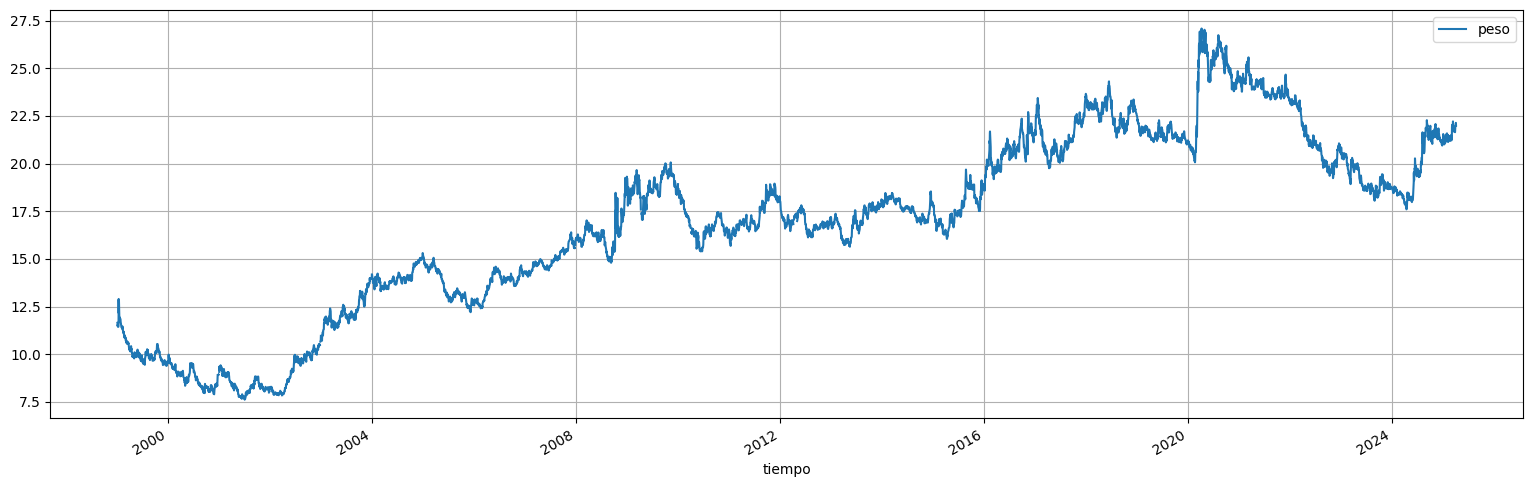

In [210]:
df.plot(
    y = 'peso',
    figsize=(19, 6),
    grid=True)

# Análisis visual
* Algo pasó en el 2020
* Los periodos han de ser de 30 dias porque los registros se ven tomados por día
* Parece que se tiene una tendencia a la alta, por lo que no se cumplirían los supuestos de estacionariedad 
* Creo que si aplicamos un autoARIMA puede pasar lo mismo que pasó en la clase y nos va a indicar que debemos hacer un polinomio de grado 0.

1) Grafico ACF y PACF para ver que me dicen
1) Voy a aplciar un autoARIMA así como está
2) Lo voy a diferenciar y volver a aplicar un autoARIMA

## PARTE 1

### Para exploración vamos a ver que hay en ACF y PACF de la serie original

<Figure size 1200x500 with 0 Axes>

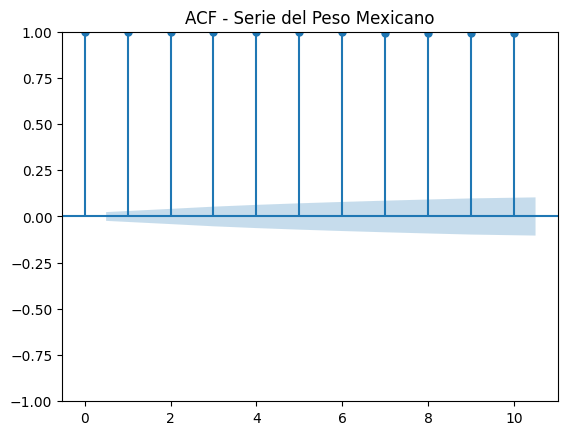

In [211]:
# Graficar ACF 
plt.figure(figsize=(12,5))
plot_acf(serie, lags=10)
plt.title("ACF - Serie del Peso Mexicano")
plt.show()

# La ACF me ayuda a saber el orden 'q' de mi modelo

<Figure size 1200x500 with 0 Axes>

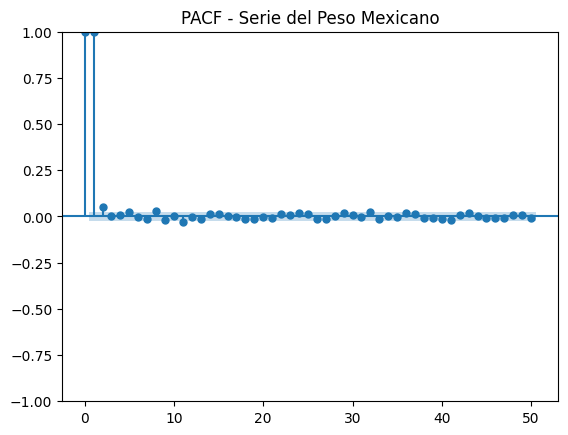

In [212]:
# Graficar PACF
plt.figure(figsize=(12,5))
plot_pacf(serie, lags=50, method='ywm')
plt.title("PACF - Serie del Peso Mexicano")
plt.show()


# La PACF se enfoca en los modelos AR, supuestamente tendriá un AR(2)

## PARTE 2

### Aplicacióń de un autoARIMA para ver la recomendación del modelo a aplciar

In [213]:
modelo = pm.auto_arima(
    serie,
    seasonal=False,   
    stepwise=True,  
    trace=True,      
    error_action="ignore",
    suppress_warnings=True
)

/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6385.926, Time=7.04 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6355.445, Time=0.60 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6390.083, Time=1.03 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6390.341, Time=0.60 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6356.756, Time=0.30 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6388.353, Time=0.67 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6388.362, Time=1.24 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6386.356, Time=1.40 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6391.532, Time=0.61 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6389.541, Time=0.74 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-6389.550, Time=0.61 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6391.283, Time=0.43 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-6387.543, Time=0.73 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 16.018 seconds


In [214]:
print(modelo.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6785
Model:               SARIMAX(0, 1, 1)   Log Likelihood                3197.766
Date:                Sat, 18 Oct 2025   AIC                          -6391.532
Time:                        20:54:54   BIC                          -6377.887
Sample:                             0   HQIC                         -6386.822
                               - 6785                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0737      0.005    -16.117      0.000      -0.083      -0.065
sigma2         0.0228      0.000    168.319      0.000       0.023       0.023
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [215]:
print("p, d, q:", modelo.order)

p, d, q: (0, 1, 1)


In [216]:
modelo = sm.tsa.SARIMAX(serie, order=(modelo.order))
resultado = modelo.fit()

print(resultado.summary())
residuos = resultado.resid

/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   peso   No. Observations:                 6785
Model:               SARIMAX(0, 1, 1)   Log Likelihood                3197.766
Date:                Sat, 18 Oct 2025   AIC                          -6391.532
Time:                        20:55:10   BIC                          -6377.887
Sample:                             0   HQIC                         -6386.822
                               - 6785                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0737      0.005    -16.117      0.000      -0.083      -0.065
sigma2         0.0228      0.000    168.319      0.000       0.023       0.023
Ljung-Box (L1) (Q):                   0.00   Jarque-

### Graficar los residuos (Diferencia entre la serie observada y la que predice este modelo)

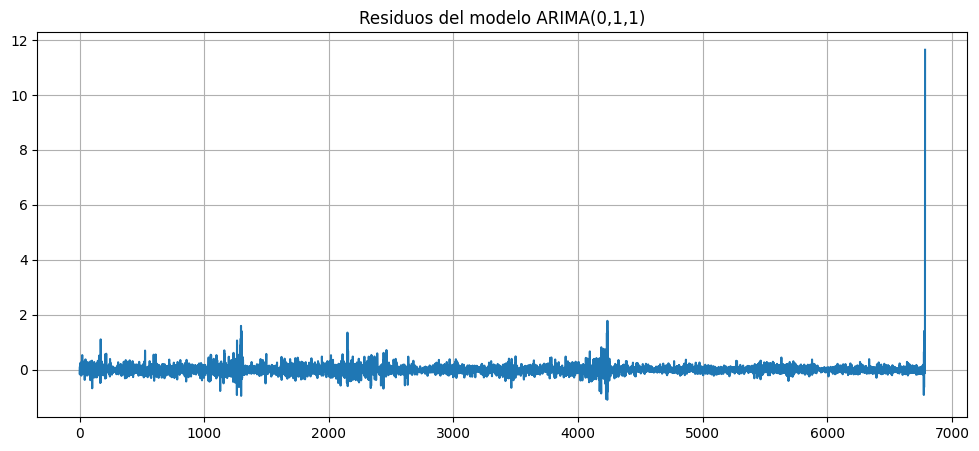

In [217]:
plt.figure(figsize=(12,5))
plt.plot(residuos)
plt.title('Residuos del modelo ARIMA(0,1,1)')
plt.grid(True)
plt.show()

### Para exploración vamos a ver que hay en ACF y PACF de los resuduos

<Figure size 1200x500 with 0 Axes>

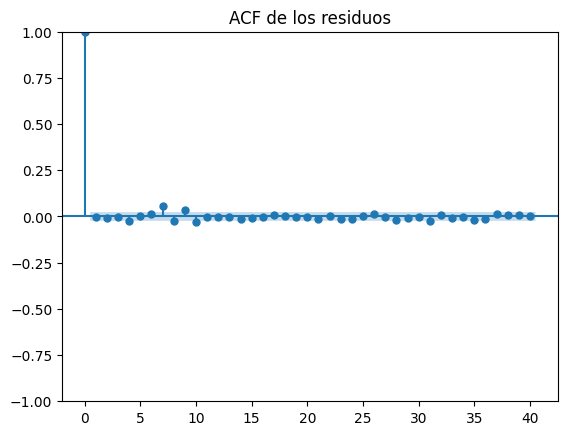

In [218]:
plt.figure(figsize=(12,5))
plot_acf(residuos, lags=40)
plt.title('ACF de los residuos')
plt.show()

# Parece que aqui cada rezago no es significativo, pero ya vi que con el p-value se hace una evaluación acumulativa hasta cierto lag
# entonces es más dificil determinar a ojo con la ACF si son ruido blanco o no.

<Figure size 1200x500 with 0 Axes>

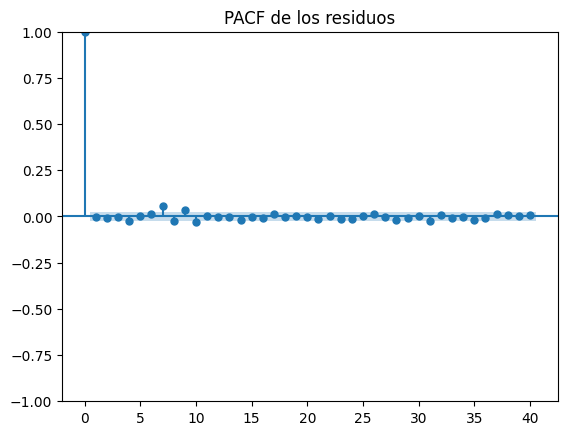

In [219]:
plt.figure(figsize=(12,5))
plot_pacf(residuos, lags=40)
plt.title('PACF de los residuos')
plt.show()

### Ljung - Box para asegurarme que es ruido blanco

In [220]:
lb_test = acorr_ljungbox(residuos, lags=[10, 20, 30, 40], return_df=True)
print(lb_test)
# Los p-values son menores que 0.05, eso hace que se rechaza la hipotesis nula y que signifique que si hay autocorrelación en los
# residuos y entonces no se comportan como ruido blanco. Este test me da autocorrelación acumulativa y es mas seguro para determinar que representa el ruido

      lb_stat  lb_pvalue
10  45.463075   0.000002
20  48.237783   0.000394
30  57.254975   0.001953
40  67.954103   0.003790


En resumen, se puede ver que hacer un analisis a la serie tal y como está no va a servir de nada, ni aplicando los parametros (p,d,q) que nos de autoARIMA.

Entonces hay que diferenciar y volver a ver que comportamiento se tiene con el modelo propuesto.

## Parte 3

In [221]:
# Una diferenciada

serie_diff_1 = serie.diff(1).dropna()

<Figure size 1200x500 with 0 Axes>

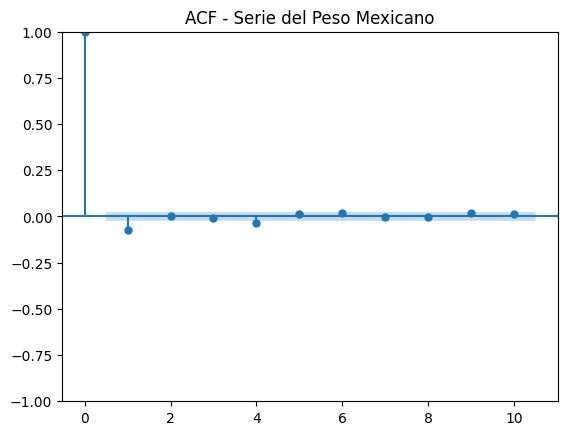

In [222]:
# Graficar ACF 
plt.figure(figsize=(12,5))
plot_acf(serie_diff_1, lags=10)
plt.title("ACF - Serie del Peso Mexicano")
plt.show()

# pues parece que se va a tener un (q) de 1

<Figure size 1200x500 with 0 Axes>

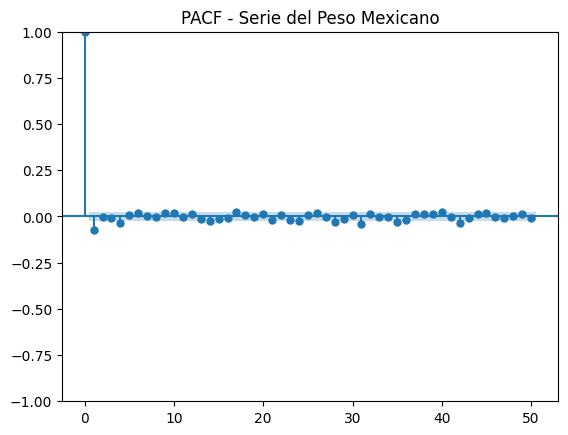

In [223]:
# Graficar PACF
plt.figure(figsize=(12,5))
plot_pacf(serie_diff_1, lags=50, method='ywm')
plt.title("PACF - Serie del Peso Mexicano")
plt.show()

# También parece que se ocuparía una (p) de 1

### Vamos a ver que dice el autoARIMA con la serie con una diferenciada

In [224]:
modelo = pm.auto_arima(
    serie_diff_1,
    seasonal=False,   
    stepwise=True,  
    trace=True,      
    error_action="ignore",
    suppress_warnings=True
)

/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-6386.325, Time=1.89 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6356.756, Time=0.32 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6391.283, Time=0.65 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6391.532, Time=0.89 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6389.541, Time=1.11 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-6389.550, Time=0.67 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-6387.543, Time=0.77 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6390.341, Time=0.52 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 6.834 seconds


In [225]:
print(modelo.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6784
Model:               SARIMAX(0, 0, 1)   Log Likelihood                3197.766
Date:                Sat, 18 Oct 2025   AIC                          -6391.532
Time:                        20:56:30   BIC                          -6377.887
Sample:                             0   HQIC                         -6386.822
                               - 6784                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0737      0.005    -16.117      0.000      -0.083      -0.065
sigma2         0.0228      0.000    168.319      0.000       0.023       0.023
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [226]:
print(modelo.order)
# Según esto solo seria un modelo MA el que serviría para esta serie

(0, 0, 1)


### Entrenar el modelo propuesto por autoARIMA con la serie diferenciada

In [227]:
modelo = sm.tsa.SARIMAX(serie_diff_1, order=(modelo.order))
resultado = modelo.fit()

print(resultado.summary())
residuos = resultado.resid

/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   peso   No. Observations:                 6784
Model:               SARIMAX(0, 0, 1)   Log Likelihood                3197.766
Date:                Sat, 18 Oct 2025   AIC                          -6391.532
Time:                        20:56:46   BIC                          -6377.887
Sample:                             0   HQIC                         -6386.822
                               - 6784                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0737      0.005    -16.117      0.000      -0.083      -0.065
sigma2         0.0228      0.000    168.319      0.000       0.023       0.023
Ljung-Box (L1) (Q):                   0.00   Jarque-

/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Graficar los residuos del modelo para diff(1)

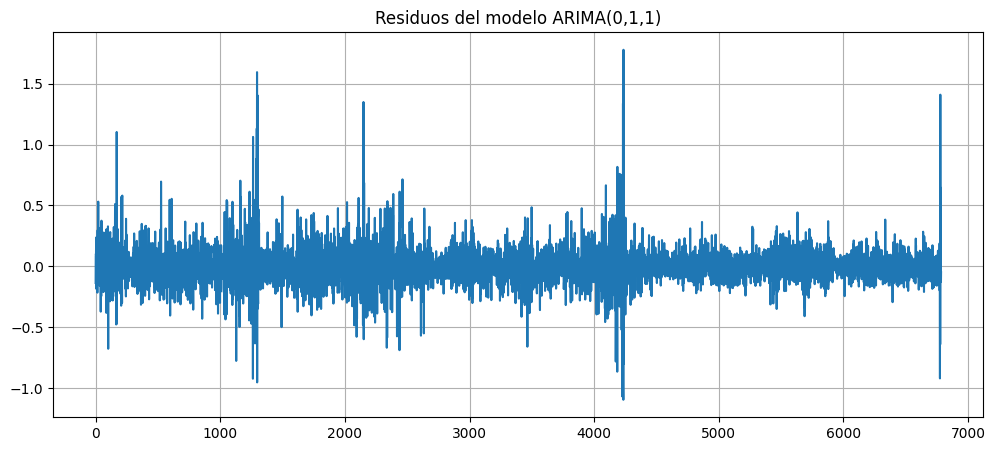

In [228]:
plt.figure(figsize=(12,5))
plt.plot(residuos)
plt.title('Residuos del modelo ARIMA(0,1,1)')
plt.grid(True)
plt.show()

### Ahora hay que ver el comportamiento de estos residuos, otra vez, primero visualmente aunque creo que no sirve mucho y despues con Ljung-Box

<Figure size 1200x500 with 0 Axes>

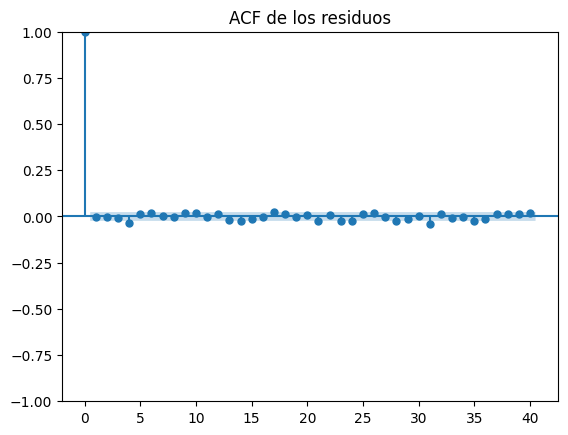

In [229]:
plt.figure(figsize=(12,5))
plot_acf(residuos, lags=40)
plt.title('ACF de los residuos')
plt.show()

# Creo que nada sirve

<Figure size 1200x500 with 0 Axes>

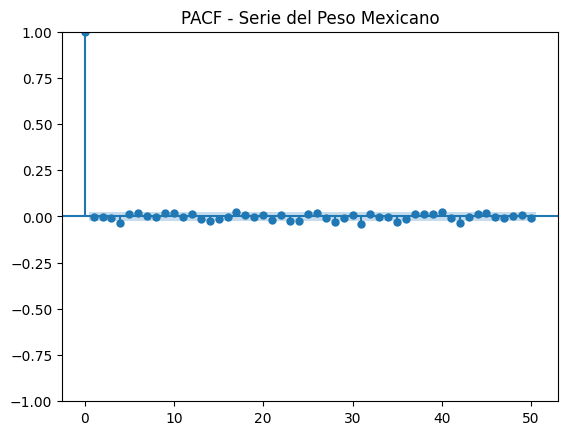

In [230]:
# Graficar PACF
plt.figure(figsize=(12,5))
plot_pacf(residuos, lags=50, method='ywm')
plt.title("PACF - Serie del Peso Mexicano")
plt.show()

# Según pareciera que todo se comporta como ruido

In [231]:
lb_test = acorr_ljungbox(residuos, lags=[10, 20, 30, 40], return_df=True)
print(lb_test)
# Esos valores de 0 han de indicar que para nada tienen el comportamiento de ruido blando y que no funciona solo con una diferenciada, entonces
# hay que provar con 2 y ver que pasa

      lb_stat  lb_pvalue
10  15.606718   0.111458
20  30.397738   0.063660
30  51.565997   0.008479
40  76.908686   0.000404


# ---------------------------------------------------- EXPERIMENTOS -----------------------------------------------------------

### Repetir el proceso con n diferenciadas

In [279]:
# Una diferenciada
n = 6
serie_diff_n = serie.diff(n).dropna()

<Figure size 1200x500 with 0 Axes>

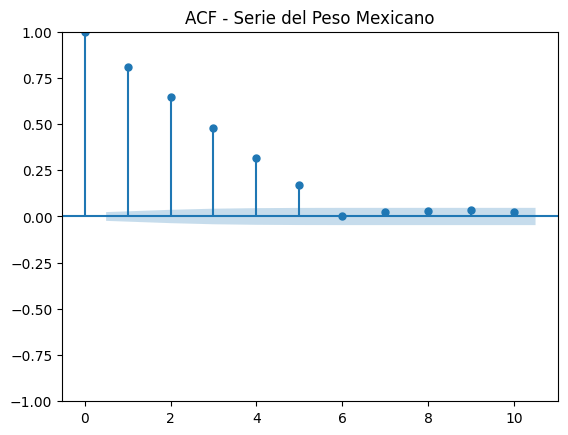

In [280]:
# Graficar ACF 
plt.figure(figsize=(12,5))
plot_acf(serie_diff_n, lags=10)
plt.title("ACF - Serie del Peso Mexicano")
plt.show()

# Tal vez indica hasta el 2 para MA

<Figure size 1200x500 with 0 Axes>

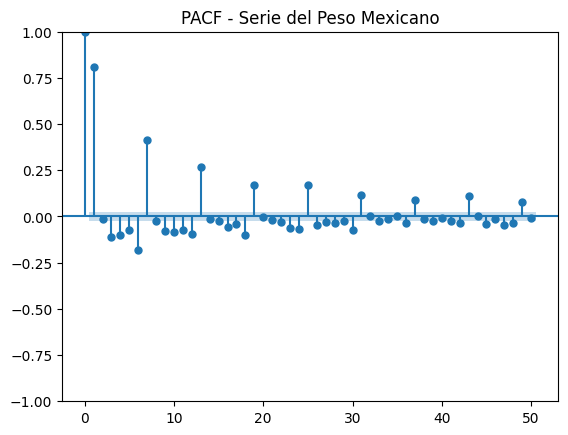

In [281]:
# Graficar PACF
plt.figure(figsize=(12,5))
plot_pacf(serie_diff_n, lags=50, method='ywm')
plt.title("PACF - Serie del Peso Mexicano")
plt.show()

#Esto ya se comportó muy diferente, pero es un orden muy alto. Parece que hay significativos hasta como el 20 para AR

### Vamos a ver que dice el autoARIMA para la serie que tiene diff(2)

In [282]:
modelo = pm.auto_arima(
    serie_diff_n,
    seasonal=False,   
    stepwise=True,  
    trace=True,      
    error_action="ignore",
    suppress_warnings=True
)

/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-2650.890, Time=2.54 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4712.273, Time=0.26 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-2446.162, Time=0.73 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=306.717, Time=0.66 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-2505.962, Time=0.75 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-2442.597, Time=1.80 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=4.89 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=3.29 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2445.680, Time=0.56 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-2982.647, Time=4.14 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-1950.288, Time=1.38 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=7.51 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-1819.491, Time=1.09 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=4.36 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=7.28 sec


/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=7.89 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0]          
Total fit time: 49.158 seconds


In [283]:
print(modelo.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6779
Model:               SARIMAX(1, 0, 3)   Log Likelihood                1496.324
Date:                Sat, 18 Oct 2025   AIC                          -2982.647
Time:                        21:11:22   BIC                          -2948.540
Sample:                             0   HQIC                         -2970.875
                               - 6779                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6384      0.005    132.598      0.000       0.629       0.648
ma.L1         -0.0102      0.002     -4.165      0.000      -0.015      -0.005
ma.L2          0.0181      0.002      8.606      0.0

In [284]:
print(modelo.order)

(1, 0, 3)


### Vamos a entrenar esa propuesta de autoARIMA

In [285]:
modelo = sm.tsa.SARIMAX(serie, order=(modelo.order))
resultado = modelo.fit()

print(resultado.summary())
residuos = resultado.resid

/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                   peso   No. Observations:                 6785
Model:               SARIMAX(1, 0, 3)   Log Likelihood                3194.027
Date:                Sat, 18 Oct 2025   AIC                          -6378.054
Time:                        21:11:30   BIC                          -6343.942
Sample:                             0   HQIC                         -6366.281
                               - 6785                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   7.08e-05   1.41e+04      0.000       1.000       1.000
ma.L1         -0.0745      0.005    -15.547      0.000      -0.084      -0.065
ma.L2         -0.0003      0.005     -0.075      0.9

### Graficar los residuos para diff(n)

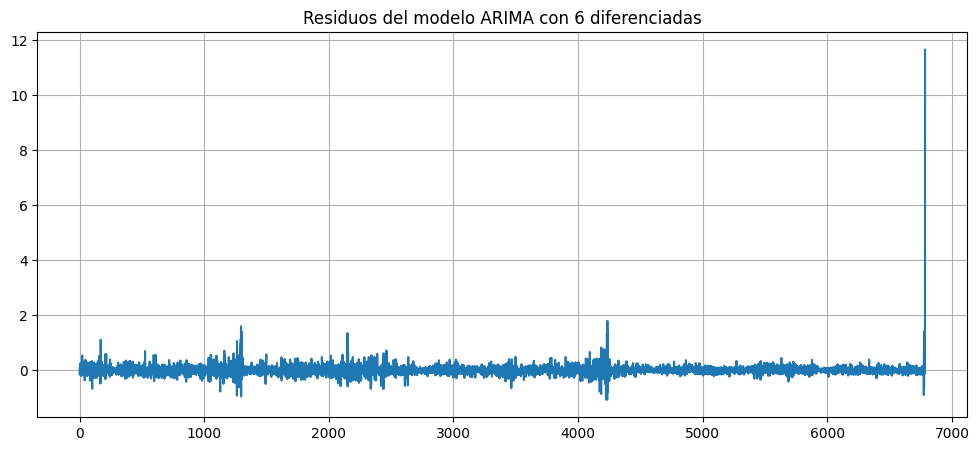

In [286]:
plt.figure(figsize=(12,5))
plt.plot(residuos)
plt.title(f'Residuos del modelo ARIMA con {n} diferenciadas')
plt.grid(True)
plt.show()

### ANalizar los residuos para diff(n), primero visualmente con ACF y con PACF, depsues formalmente con Ljung-BOx

<Figure size 1200x500 with 0 Axes>

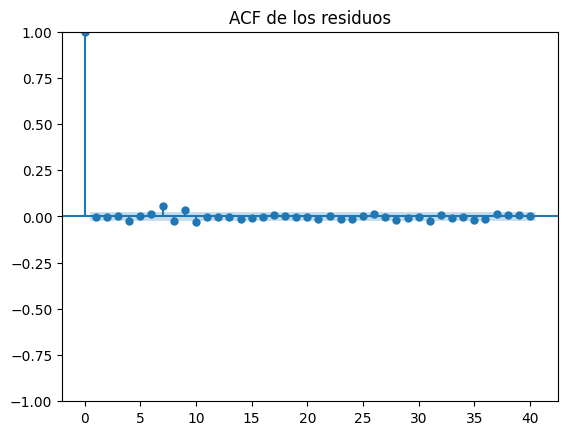

In [287]:
plt.figure(figsize=(12,5))
plot_acf(residuos, lags=40)
plt.title('ACF de los residuos')
plt.show()

# Aparentemente ruido

<Figure size 1200x500 with 0 Axes>

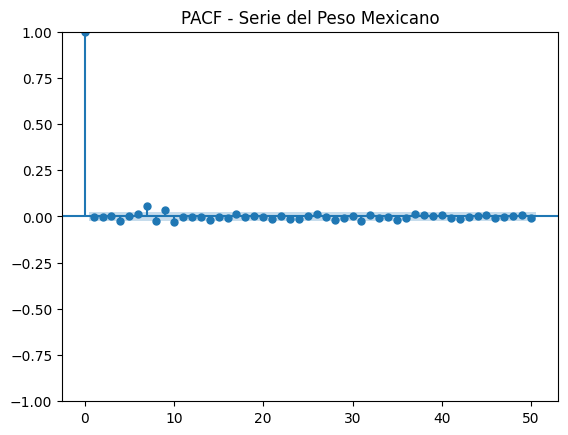

In [288]:
# Graficar PACF
plt.figure(figsize=(12,5))
plot_pacf(residuos, lags=50, method='ywm')
plt.title("PACF - Serie del Peso Mexicano")
plt.show()

# Según parece puede ser ruido

In [289]:
lb_test = acorr_ljungbox(residuos, lags=[10, 20, 30, 40], return_df=True)
print(lb_test)
# sigue rechazando la hipotesis nula

      lb_stat  lb_pvalue
10  45.140853   0.000002
20  47.895501   0.000440
30  56.959808   0.002115
40  67.628844   0.004091


# Ya le hice muchas diferenciaciónes (6) y cuando se hace el test de Ljung - Box parece que los residuos de los modelos entrenados no se comportan como ruido blanco, eso puede indicar que entonces los modelos propuestos no están captando la estructura temporal de la serie y no sirven para poder hacer predicciónes.